In [1]:
import torch
import numpy as np

torch.set_default_dtype(torch.float64)

from torch.utils.tensorboard import SummaryWriter
import tqdm

from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda")

In [3]:
data1 = torch.tensor(np.load("mu_0.9.npy")).to(device)
data2 = torch.tensor(np.load("mu_0.95.npy")).to(device)
data3 = torch.tensor(np.load("mu_1.05.npy")).to(device)
data4 = torch.tensor(np.load("mu_1.1.npy")).to(device)

dt = 2 / 1500

X = torch.cat([data1, data2, data3, data4], axis=0)
x_ref = torch.mean(X, dim=0)
(S, N) = X.shape

X_test = torch.tensor(np.load("mu_1.0.npy")).to(device)

In [4]:
class NRBS(torch.nn.Module):
    def __init__(self, N, n, M1, M2, b):
        super(NRBS, self).__init__()

        mask = torch.zeros(N, M2)
        shift = (M2 - b) / (N - 1)

        for i in range(N):
            mask[i, int(np.ceil(shift*i)): int(np.ceil(shift*i)) + b] = 1

        new_mask = torch.zeros(N, M2)

        for idx in range(N):
            i = idx // 60
            j = idx % 60
            neighbours = [(i, j), (i-1, j), (i+1, j), (i, j+1), (i, j-1)]
            for neighbour_i, neighbour_j in neighbours:
              if (neighbour_i >=0 and neighbour_i < 60) and (neighbour_j >=0 and neighbour_j < 60):
                new_mask[idx] = new_mask[idx] + mask[60*neighbour_i + neighbour_j]

        new_mask[new_mask > 0] = 1

        self.register_buffer('mask', new_mask)


        self.encoder1 = torch.nn.Linear(N, M1)
        self.encoder2 = torch.nn.Linear(M1, n)

        self.decoder1 = torch.nn.Linear(n, M2)
        self.decoder2 = torch.nn.Linear(M2, N)

        torch.nn.init.kaiming_normal_(self.encoder1.weight)
        torch.nn.init.kaiming_normal_(self.encoder2.weight)
        torch.nn.init.kaiming_normal_(self.decoder1.weight)
        torch.nn.init.kaiming_normal_(self.decoder2.weight)

    def encode(self, x):
        x = self.encoder1(x)
        x = x * torch.sigmoid(x)
        x = self.encoder2(x)
        return x

    def decode(self, x):
        x = self.decoder1(x)
        x = x * torch.sigmoid(x)
        x = torch.matmul(x, (self.decoder2.weight * self.get_buffer('mask')).T) + self.decoder2.bias
        return x

    def forward(self, x):
        return self.decode(self.encode(x))


In [5]:
n = 20

nrbs = NRBS(N, n, 6728, 33730, 70).to(device)
nrbs = torch.load('models/shallow_mask_old.pth')

X_tilde = nrbs(X_test - x_ref) + x_ref
l_test = torch.sqrt(torch.sum((X_test - X_tilde) ** 2)) / torch.sqrt(
    torch.sum(X_test**2)
)
l_test

tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)

In [6]:
def u_hat_and_u_hat_dot(nrbs, u, u_ref, dt):
    with torch.no_grad():
        u_hat = nrbs.encode(u - u_ref)
        u_hat_dot = (u_hat[1:] - u_hat[:-1]) / dt
        u_hat = u_hat[1:]
    return u_hat, u_hat_dot

In [7]:
data1_hat, data1_hat_dot = u_hat_and_u_hat_dot(nrbs, data1, x_ref, dt)
data2_hat, data2_hat_dot = u_hat_and_u_hat_dot(nrbs, data2, x_ref, dt)
data3_hat, data3_hat_dot = u_hat_and_u_hat_dot(nrbs, data3, x_ref, dt)
data4_hat, data4_hat_dot = u_hat_and_u_hat_dot(nrbs, data4, x_ref, dt)


In [8]:
X_hat = torch.cat([data1_hat, data2_hat, data3_hat, data4_hat])
X_hat_dot = torch.cat([data1_hat_dot, data2_hat_dot, data3_hat_dot, data4_hat_dot])

X_hat_test, X_hat_dot_test = u_hat_and_u_hat_dot(nrbs, X_test, x_ref, dt)

In [9]:
class OP(torch.nn.Module):
    def __init__(self, n, M):
        super(OP, self).__init__()

        ls = []
        in_dim = n
        for dim in M:
            ls.append(torch.nn.Linear(in_dim, dim))
            in_dim = dim
        self.ls = torch.nn.ModuleList(ls)

        # self.residual = torch.nn.Linear(n, n)

    def forward(self, x):
        # residual = self.residual(x)
        for i in range(len(self.ls) - 1):
            x = self.ls[i](x)
            x = x * torch.sigmoid(x)
        x = self.ls[-1](x)
        # x = x + residual
        return x


In [10]:
lr = 1e-3
epochs = 10000
B = 240
lr_red_factor = 0.1
patience = 10
l1_reg = 0

# op = OP(n, [500, 1000, 500, n]).to(device)
op = OP(n, [600, 1000, 1200, 1000, 600, n]).to(device)
# op = torch.load('models/operator.pth')

In [11]:
# with torch.no_grad():
#     approximates = op(X_hat_test)
#     l_test = torch.sum((X_hat_dot_test - approximates) ** 2)

# torch.sqrt(l_test) / torch.sqrt(torch.sum(X_hat_dot_test**2))

tensor(0.0023, device='cuda:0')

In [12]:
data = torch.utils.data.TensorDataset(X_hat, X_hat_dot)
dataloader = torch.utils.data.DataLoader(data, batch_size=B, shuffle=True)

optimizer = torch.optim.Adam(op.parameters(), lr=lr, weight_decay=l1_reg)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=lr_red_factor, patience=patience
)

best_loss = 1000
writer = SummaryWriter()
for epoch in range(epochs):
    for x, x_dot in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        loss = torch.sqrt(torch.sum((op(x) - x_dot) ** 2))
        loss.backward()
        # print(op.l1.weight.grad)
        optimizer.step()

    with torch.no_grad():
        approximates = op(X_hat)
        l_train = torch.sum((X_hat_dot - approximates) ** 2)

        approximates = op(X_hat_test)
        l_test = torch.sum((X_hat_dot_test - approximates) ** 2)

    if (l_train < best_loss):
        best_loss = l_train
        torch.save(op, 'models/operator.pth')
        

    scheduler.step(l_train)

    writer.add_scalar("loss/train", torch.sqrt(l_train) / torch.sqrt(torch.sum(X_hat_dot**2)), epoch)
    writer.add_scalar("loss/mse_train", l_train / X_hat_dot.shape[1] / X_hat_dot.shape[0], epoch)
    
    writer.add_scalar("loss/test", torch.sqrt(l_test) / torch.sqrt(torch.sum(X_hat_dot_test**2)), epoch)
    writer.add_scalar("loss/mse_train", l_test / X_hat_dot_test.shape[1] / X_hat_dot_test.shape[0], epoch)

    writer.add_scalar("lr", optimizer.param_groups[0]["lr"], epoch)
    print(torch.sqrt(l_train) / torch.sqrt(torch.sum(X_hat_dot**2)))
    print(torch.sqrt(l_test) / torch.sqrt(torch.sum(X_hat_dot_test**2)))

In [13]:
# test = X_hat_test[0]
# test.requires_grad = True
# test_dot = op(test)

In [14]:
# basis = torch.zeros(n, n)
# for i in range(n):
#     inplace = torch.zeros_like(test_dot)
#     inplace[i] = 1
#     basis[:, i] = torch.autograd.grad(test_dot, test, inplace, retain_graph=True)[0]

In [15]:
def nr_solve(f, df, x, atol=1e-10, rtol=1e-8, max_itr=50, args=None):
    r = f(x, *args)
    r0_norm = torch.linalg.norm(r)
    print("Itr = {:}, residual norm = {:.4E}".format(0, r0_norm))
    if (r0_norm < atol):
        return x
    for i in range(max_itr):
        x = torch.linalg.solve(df(x, *args), -r) + x
        r = f(x, *args)
        print("Itr = {:}, residual norm = {:.4E}".format(i + 1, torch.linalg.norm(r)))
        if (torch.linalg.norm(r) < atol or torch.linalg.norm(r) / r0_norm < rtol):
            return x
    raise Exception("solve failed")
        

In [16]:
# replace with NN: u_hat to u_hat_dot
def f(x, x_old, dt):
    x_dot = op(x)
    return x - x_old - dt * x_dot

def df(x, x_old, dt):
    print(x.requires_grad)
    x_dot = op(x)
    d_s_dot = torch.zeros(n, n).to(device)
    for i in range(n):
        inplace = torch.zeros_like(x_dot)
        inplace[i] = 1
        d_s_dot[:, i] = torch.autograd.grad(x_dot, x, inplace, retain_graph=True)[0]

    return torch.eye(n).to(device) - d_s_dot * dt

In [17]:
# x_red = X_hat_test[0]
# x_red.requires_grad = True
# x_red = nr_solve(f, df, x_red, args=(x_red, dt))

In [18]:
x_red = X_hat_test[0]
x_red.requires_grad = True
t = 0
sol = {t : x_red}
dt = 2 / 1500
dt_min = dt / 100
while t < 2:
    print('Time = {:}, dt = {:}'.format(t + dt, dt))
    try:
        x_red = nr_solve(f, df, x_red, args=(x_red, dt))
    except:
        dt = dt / 2
        if (dt < dt_min):
            raise Exception("dt is too small")
        continue
    t = t + dt
    sol[t] = x_red

Time = 0.0013333333333333333, dt = 0.0013333333333333333
Itr = 0, residual norm = 4.6897E-02
True
Itr = 1, residual norm = 1.4416E-03
True
Itr = 2, residual norm = 4.5979E-05
True
Itr = 3, residual norm = 1.4827E-06
True
Itr = 4, residual norm = 4.7862E-08
True
Itr = 5, residual norm = 1.5556E-09
True
Itr = 6, residual norm = 5.0369E-11
Time = 0.0026666666666666666, dt = 0.0013333333333333333
Itr = 0, residual norm = 4.6750E-02
True
Itr = 1, residual norm = 1.4385E-03
True
Itr = 2, residual norm = 4.5957E-05
True
Itr = 3, residual norm = 1.4846E-06
True
Itr = 4, residual norm = 4.8018E-08
True
Itr = 5, residual norm = 1.5637E-09
True
Itr = 6, residual norm = 5.0733E-11
Time = 0.004, dt = 0.0013333333333333333
Itr = 0, residual norm = 4.6600E-02
True
Itr = 1, residual norm = 1.4355E-03
True
Itr = 2, residual norm = 4.5944E-05
True
Itr = 3, residual norm = 1.4872E-06
True
Itr = 4, residual norm = 4.8204E-08
True
Itr = 5, residual norm = 1.5732E-09
True
Itr = 6, residual norm = 5.1155E-11

In [19]:
t

2.0000000000000457

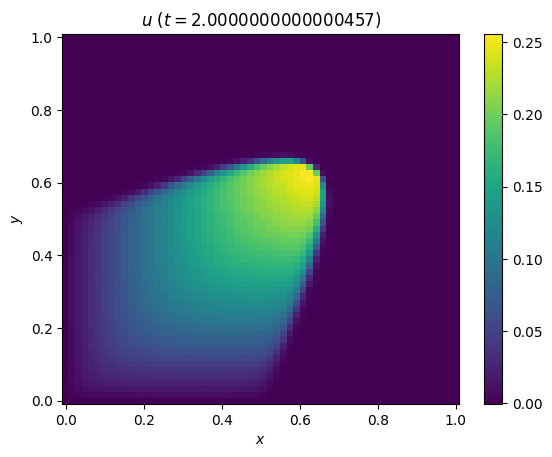

In [20]:
approximate = (nrbs.decode(sol[t]) + x_ref).detach().cpu().numpy()
# plot
ny = 60
nx = 60
x = np.load('paper_x.npy')
y = np.load('paper_y.npy')


fig_u = plt.figure()
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (approximate).reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$ ($t = {:}$)'.format(t))
plt.show()

In [21]:
ref_sol = X_test[-1]
approximate = (nrbs.decode(sol[t]) + x_ref)
torch.sqrt(torch.sum(approximate - ref_sol)**2) / torch.sqrt(torch.sum(ref_sol**2))

tensor(0.0578, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
# for t, x_red in sol.items():
#     approximate = (nrbs.decode(x_red) + x_ref).detach().cpu().numpy()
#     # plot
#     ny = 60
#     nx = 60
#     x = np.load('paper_x.npy')
#     y = np.load('paper_y.npy')


#     fig_u = plt.figure()
#     ax_u = fig_u.gca()
#     p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (approximate).reshape(ny,nx))
#     cb_u=fig_u.colorbar(p_u,ax=ax_u)
#     ax_u.set_xlabel('$x$')
#     ax_u.set_ylabel('$y$')
#     plt.title('$u$ ($t = {:}$)'.format(t))
#     plt.show()